In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV2, VGG19, DenseNet121
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras import layers

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import seaborn as sns

In [ ]:
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from imutils import paths

In [ ]:
imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/Skripsi/data")))

# random shuffle
random.seed(42)
random.shuffle(imagePaths)

data = []
labels = []
image_dims = (224, 224, 3)

for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (image_dims[1], image_dims[0]))
    image = img_to_array(image)
    data.append(image)
    l = label = imagePath.split(os.path.sep)[-2].split("_")
    labels.append(l)

data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("{} images ({:.2f}MB)".format(len(imagePaths), data.nbytes / (1024 * 1000.0)))

507 images (596.23MB)


In [ ]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
)

In [ ]:
data = np.array(data)
label = np.array(labels)
print(data.shape)

(507, 224, 224, 3)


In [ ]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
# total 4 labels
print("class labels:")
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i + 1, label))

class labels:
1. boulder
2. branching
3. table


In [ ]:
print(labels)

[[0 1 0]
 [0 1 0]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [0 1 0]]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
bs = 8
lr = 0.001
size = (224, 224)
shape = (224,224, 3)
epochs = 20
class_number = 3

In [ ]:

def DenseNet_model(learning_rate, input_shape,class_number):
    densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape)

    for layer in densenet.layers[:-4]:
        layer.trainable = False

    model = Sequential()
    model.add(densenet)
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(layers.Dense(class_number, activation='softmax'))

    return model


In [ ]:
model = DenseNet_model(lr,shape,class_number)
model.compile(loss= "categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 1024)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 512)               4719104   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                        

In [ ]:
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.20)

In [ ]:
print("[INFO] training ...")
H = model.fit(aug.flow(trainX, trainY, batch_size=bs),steps_per_epoch=len(trainX) // bs,	validation_data=(testX, testY),	validation_steps=len(testX) // bs,	epochs=epochs)

[INFO] training ...
Epoch 1/20
50/50 [==============================] - 113s 2s/step - loss: 2.5329 - accuracy: 0.7657 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 2/20
50/50 [==============================] - 80s 2s/step - loss: 1.3926 - accuracy: 0.8841 - val_loss: 0.0961 - val_accuracy: 0.9902
Epoch 3/20
50/50 [==============================] - 82s 2s/step - loss: 0.9724 - accuracy: 0.8816 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 4/20
50/50 [==============================] - 84s 2s/step - loss: 0.5621 - accuracy: 0.9144 - val_loss: 2.8913e-04 - val_accuracy: 1.0000
Epoch 5/20
50/50 [==============================] - 87s 2s/step - loss: 0.2831 - accuracy: 0.9547 - val_loss: 0.0751 - val_accuracy: 0.9902
Epoch 6/20
50/50 [==============================] - 84s 2s/step - loss: 0.4144 - accuracy: 0.9244 - val_loss: 0.0866 - val_accuracy: 0.9804
Epoch 7/20
50/50 [==============================] - 86s 2s/step - loss: 0.2284 - accuracy: 0.9345 - val_loss: 9.4210e-04 - val_accuracy

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=bs)
y_predict =predIdxs
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=mlb.classes_))

[INFO] evaluating network...
13/13 [==============================] - 17s 1s/step
              precision    recall  f1-score   support

     boulder       1.00      1.00      1.00        35
   branching       1.00      1.00      1.00        54
       table       1.00      1.00      1.00        13

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102



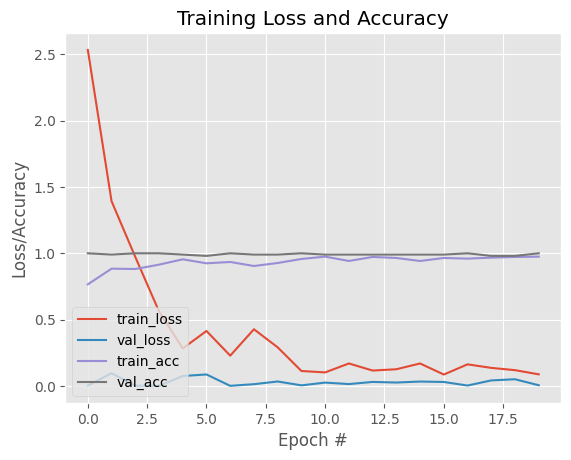

In [ ]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

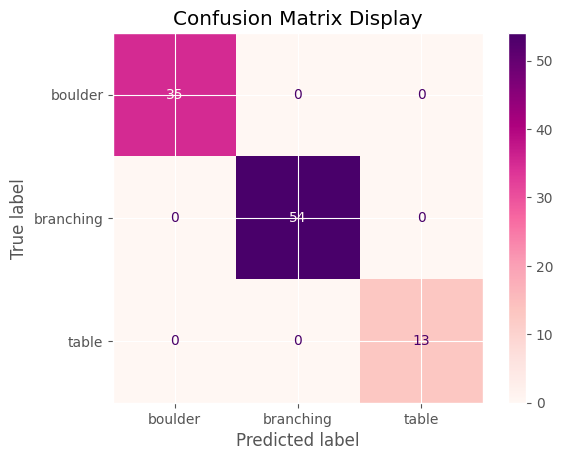

In [ ]:
# Pembuatan Confusion Matrix Display
cmd= metrics.confusion_matrix(testY.argmax(axis=1), np.argmax(y_predict, axis=1))
display_label = ['boulder','branching','table']

cm_lr= ConfusionMatrixDisplay(cmd, display_labels = display_label )
cm_lr.plot(cmap=plt.cm.RdPu)
plt.title("Confusion Matrix Display")

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Skripsi/model/densenet_model_1.h5')
